*** @Author: Amar Pawar ***

*** @Date: 2021-08-28 ***

*** @Last Modified by: Amar Pawar ***

*** @Last Modified time: 2021-08-28 ***

*** @Title : Storing data on hive table by pre proccessing with spark and accessing with hive queries ***

# Creating spark session

In [1]:
from pyspark.sql import SparkSession
from logging_handler import logger
try:
    appName = "PySpark hive example"
    master = "local"
    spark = SparkSession.builder.master(master).appName(appName).enableHiveSupport().getOrCreate()

except Exception as e:
    logger.info(e)

2021-08-27 15:35:19,790 WARN util.NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


In [3]:
df = spark.read.csv("hdfs://localhost:9000/Spark/CpuLogData/*.csv",header=True)
df2 = df.select("user_name","DateTime","keyboard","mouse")

In [4]:
df2.show()

+--------------------+-------------------+--------+------+
|           user_name|           DateTime|keyboard| mouse|
+--------------------+-------------------+--------+------+
|  iamnzm@outlook.com|2019-09-19 08:40:02|     1.0|  32.0|
|  iamnzm@outlook.com|2019-09-19 08:45:02|     0.0|   0.0|
|  iamnzm@outlook.com|2019-09-19 08:50:01|     0.0|   0.0|
|  iamnzm@outlook.com|2019-09-19 08:55:01|    11.0| 900.0|
|  iamnzm@outlook.com|2019-09-19 09:00:01|     2.0|  25.0|
|  iamnzm@outlook.com|2019-09-19 09:05:01|    37.0| 336.0|
|deepshukla292@gma...|2019-09-19 09:05:01|     0.0|  55.0|
|  iamnzm@outlook.com|2019-09-19 09:10:01|     0.0| 136.0|
|deepshukla292@gma...|2019-09-19 09:10:01|     6.0|1112.0|
|  iamnzm@outlook.com|2019-09-19 09:15:02|     0.0|  84.0|
|deepshukla292@gma...|2019-09-19 09:15:02|     0.0| 357.0|
|markfernandes66@g...|2019-09-19 09:15:01|    20.0| 670.0|
|markfernandes66@g...|2019-09-19 09:10:01|    17.0|   0.0|
|markfernandes66@g...|2019-09-19 09:20:01|    29.0|1895.

In [ ]:
df2.createOrReplaceTempView("data")

# Loading data from dataframe to hive table

In [ ]:
try:
    spark.sql("create table default.new_data as select * from data")
    #df2.write.format("orc").mode("overwrite").saveAsTable("default.new_data")
except Exception as e:
    logger.info(e)

In [1]:
from pyhive import hive
import pandas as pd

In [2]:
conn = hive.Connection(host='localhost',port=10000,database='default')

In [ ]:
user_count=pd.read_sql("select user_name, count('') as total_count from new_data group by user_name",conn)
print(user_count)

In [ ]:
df4=spark.sql("select * from default.new_data")
df4.show()

In [3]:
df5 = pd.read_sql("select user_name ,count('') as total from new_data where keyboard !=0.0 or mouse!=0.0 group by user_name",conn)
print(df5)

                      user_name  total
0  bhagyashrichalke21@gmail.com    361
1         damodharn21@gmail.com    191
2       deepshukla292@gmail.com    475
3            iamnzm@outlook.com    459
4     markfernandes66@gmail.com    389
5         rahilstar11@gmail.com    399
6      salinabodale73@gmail.com    440
7         sharlawar77@gmail.com    457


# LOWEST AVG HOURS

In [4]:
lowest_work_time=pd.read_sql("select user_name ,((((count('')-1)*5)*60)/6) as working_sec from new_data where keyboard!=0.0 or mouse!=0.0 group by user_name",conn)
lowest_work_time = lowest_work_time.sort_values('working_sec')
print(lowest_work_time)

                      user_name  working_sec
1         damodharn21@gmail.com       9500.0
0  bhagyashrichalke21@gmail.com      18000.0
4     markfernandes66@gmail.com      19400.0
5         rahilstar11@gmail.com      19900.0
6      salinabodale73@gmail.com      21950.0
7         sharlawar77@gmail.com      22800.0
3            iamnzm@outlook.com      22900.0
2       deepshukla292@gmail.com      23700.0


In [5]:
lowest_average_work_hour = lowest_work_time[["user_name","working_sec"]]
lowest_average_work_hour["working_sec"]= pd.to_datetime(lowest_average_work_hour['working_sec'] ,unit='s').dt.strftime("%H:%M")
lowest_average_work_hour = lowest_average_work_hour.sort_values('working_sec')
lowest_average_work_hour.rename(columns={'working_sec': 'working_hour'}, inplace=True)
print(lowest_average_work_hour)

                      user_name working_hour
1         damodharn21@gmail.com        02:38
0  bhagyashrichalke21@gmail.com        05:00
4     markfernandes66@gmail.com        05:23
5         rahilstar11@gmail.com        05:31
6      salinabodale73@gmail.com        06:05
7         sharlawar77@gmail.com        06:20
3            iamnzm@outlook.com        06:21
2       deepshukla292@gmail.com        06:35


# HIGHEST AVG HOURS

In [6]:
highest_work_time=pd.read_sql("select user_name ,((((count('')-1)*5)*60)/6) as working_sec from new_data where keyboard!=0.0 or mouse!=0.0 group by user_name",conn)
highest_work_time= highest_work_time.sort_values(by='working_sec',ascending=False)
print(highest_work_time)

                      user_name  working_sec
2       deepshukla292@gmail.com      23700.0
3            iamnzm@outlook.com      22900.0
7         sharlawar77@gmail.com      22800.0
6      salinabodale73@gmail.com      21950.0
5         rahilstar11@gmail.com      19900.0
4     markfernandes66@gmail.com      19400.0
0  bhagyashrichalke21@gmail.com      18000.0
1         damodharn21@gmail.com       9500.0


In [7]:
highest_average_work_hour = highest_work_time[["user_name","working_sec"]]
highest_average_work_hour["working_sec"]= pd.to_datetime(highest_average_work_hour['working_sec'] ,unit='s').dt.strftime("%H:%M")
highest_average_work_hour = highest_average_work_hour.sort_values('working_sec',ascending=False)
highest_average_work_hour.rename(columns={'working_sec': 'working_hour'}, inplace=True)
print(highest_average_work_hour)

                      user_name working_hour
2       deepshukla292@gmail.com        06:35
3            iamnzm@outlook.com        06:21
7         sharlawar77@gmail.com        06:20
6      salinabodale73@gmail.com        06:05
5         rahilstar11@gmail.com        05:31
4     markfernandes66@gmail.com        05:23
0  bhagyashrichalke21@gmail.com        05:00
1         damodharn21@gmail.com        02:38


# VISUALIZATION

In [9]:
import seaborn as sns
import matplotlib.pyplot as plt

In [10]:
username= highest_work_time['user_name']
work=highest_work_time['working_sec']

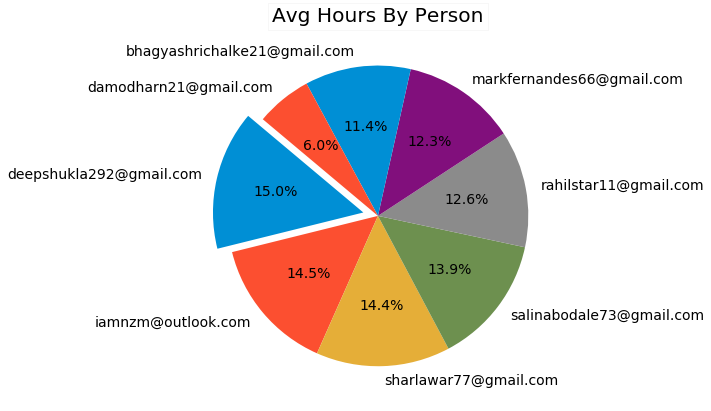

In [11]:
try:
    plt.style.use("fivethirtyeight")
    fig = plt.figure(figsize=(6,12))
    fig.patch.set_facecolor('w')
    explode = (0.1, 0, 0, 0, 0, 0, 0, 0)
    plt.pie(work,labels=username,autopct='%1.1f%%',startangle=140,explode= explode)
    plt.title('Avg Hours By Person',bbox={'facecolor':'1', 'pad':4})

except Exception as e:
    logger.info(e)

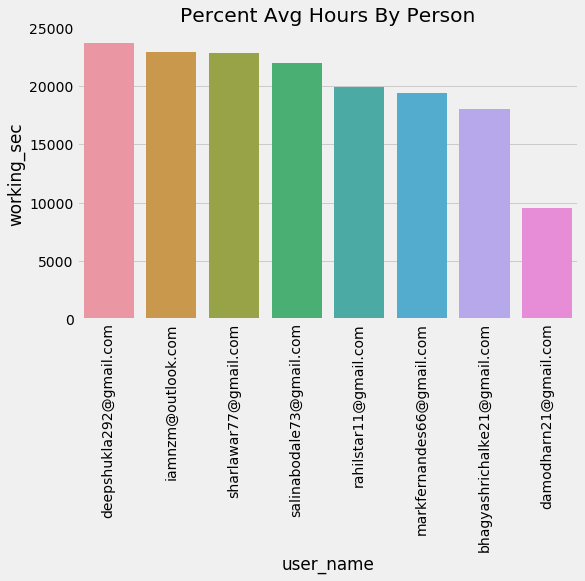

In [12]:
try:
    df = highest_work_time
    plt.figure(figsize = (8,5))
    sns.barplot(x = 'user_name',y='working_sec',data = df)
    plt.title("Percent Avg Hours By Person")
    plt.ylim(0,25000)
    plt.xticks(rotation='vertical')
    plt.show()
except Exception as e:
    logger.info(e)

# TOTAL USER COUNT

In [13]:
user_count=pd.read_sql("select user_name, count('') as total_count from new_data group by user_name",conn)
print(user_count)

                      user_name  total_count
0  bhagyashrichalke21@gmail.com          482
1         damodharn21@gmail.com          253
2       deepshukla292@gmail.com          565
3            iamnzm@outlook.com          614
4     markfernandes66@gmail.com          508
5         rahilstar11@gmail.com          551
6      salinabodale73@gmail.com          569
7         sharlawar77@gmail.com          580


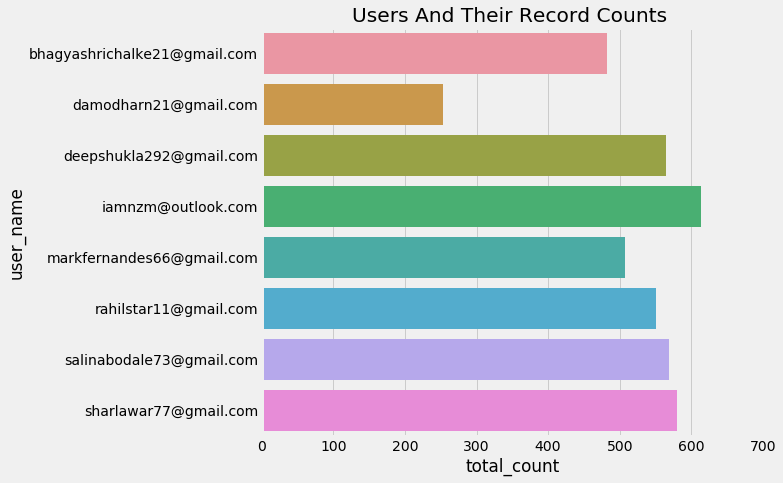

In [14]:
try:
    df = user_count
    plt.figure(figsize = (8,7))
    sns.barplot(x = 'total_count',y='user_name',data = df)
    plt.title('Users And Their Record Counts ')
    plt.xlim(0,700)
    plt.show()
except Exception as e:
    logger.info(e)

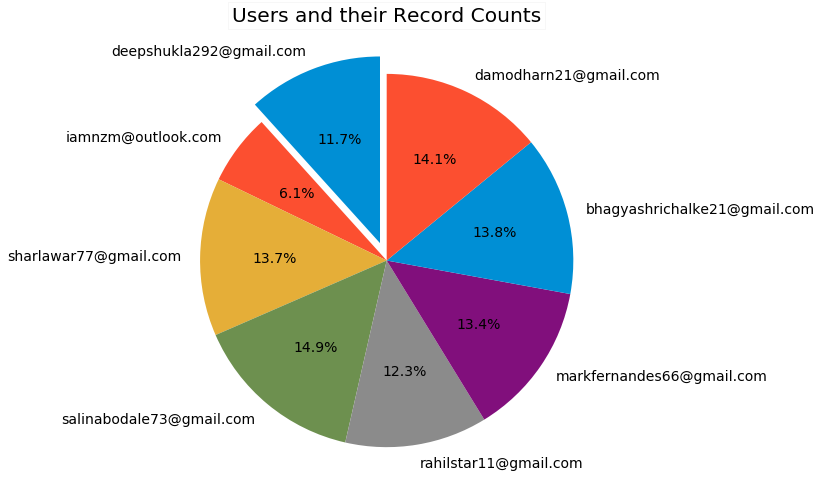

In [15]:
try:
    
    user_data = user_count["user_name"]
    count_data = user_count["total_count"]

    fig = plt.figure(figsize=(10,8))
    fig.patch.set_facecolor('w')
    explode = (0.1, 0, 0, 0, 0, 0, 0, 0)
    # Plot
    plt.pie(count_data,labels = username,autopct='%1.1f%%',startangle=90,explode=explode,)
    plt.title('Users and their Record Counts',bbox={'facecolor':'1', 'pad':4})
except Exception as e:
    logger.info(e)

# IDLE COUNT

In [16]:
idle_count = pd.read_sql("select user_name ,count('') as total from new_data where keyboard=0 and mouse=0 group by user_name",conn)
print(idle_count)

                      user_name  total
0  bhagyashrichalke21@gmail.com    121
1         damodharn21@gmail.com     62
2       deepshukla292@gmail.com     90
3            iamnzm@outlook.com    155
4     markfernandes66@gmail.com    119
5         rahilstar11@gmail.com    152
6      salinabodale73@gmail.com    129
7         sharlawar77@gmail.com    123


In [18]:
highest_idle_time = pd.read_sql("select user_name ,((((count('')-1)*5)*60)/6) as idle_sec from new_data where keyboard=0.0 and mouse=0.0 group by user_name",conn)
highest_idle_time=highest_idle_time.sort_values(by='idle_sec',ascending=False)
print(highest_idle_time)

                      user_name  idle_sec
3            iamnzm@outlook.com    7700.0
5         rahilstar11@gmail.com    7550.0
6      salinabodale73@gmail.com    6400.0
7         sharlawar77@gmail.com    6100.0
0  bhagyashrichalke21@gmail.com    6000.0
4     markfernandes66@gmail.com    5900.0
2       deepshukla292@gmail.com    4450.0
1         damodharn21@gmail.com    3050.0


In [19]:
idle_hour = highest_idle_time[["user_name","idle_sec"]]
idle_hour["idle_sec"]= pd.to_datetime(idle_hour['idle_sec'] ,unit='s').dt.strftime("%H:%M")
idle_hour = idle_hour.sort_values('idle_sec',ascending=False)
idle_hour.rename(columns={'idle_sec': 'idle_hour'}, inplace=True)
print(idle_hour)

                      user_name idle_hour
3            iamnzm@outlook.com     02:08
5         rahilstar11@gmail.com     02:05
6      salinabodale73@gmail.com     01:46
7         sharlawar77@gmail.com     01:41
0  bhagyashrichalke21@gmail.com     01:40
4     markfernandes66@gmail.com     01:38
2       deepshukla292@gmail.com     01:14
1         damodharn21@gmail.com     00:50


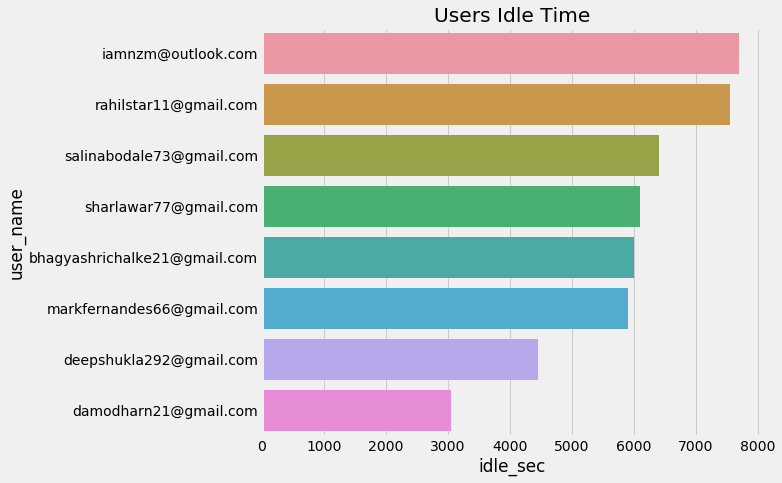

In [20]:
try:
    df = highest_idle_time
    plt.figure(figsize = (8,7))
    sns.barplot(x = 'idle_sec',y='user_name',data = df)
    plt.title('Users Idle Time')
    plt.show()
except Exception as e:
    logger.info(e)